In [1]:
import pandas as pd
import sys
import recursive_lengths as rl
import minimize_lengths as mn
from scipy.stats import linregress
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Functions 

In [2]:
#for plots
font = {
        'weight' : 'bold',
        'size'   : 9}
plt.rc('axes', labelsize='x-large')
matplotlib.rc('font', **font)

In [3]:
# Basic statistics
def load_and_filer(pwd,r=0.95):
    """Load and filter the files"""
    df = pd.read_csv(pwd)
    # Create the "string" lane_ID= date+pos+gl and cell=date+pos+gl+id
    df = rl.give_good_structure(df)
    # Filter only cells which end with DIVISION
    df = df.loc[(df['end_type']=='DIVISION')|(df['end_type']=='DIV')]
    # Convert the length in micrometers and the frames in seconds 
    if 'length_box' in df.columns: 
        df['time_sec'] = df['frame']*60*3
        df['length_box_um'] = df['length_box']*0.065
    # Keep only cells which have more than 2 datapoints
    df = df.groupby('cell').filter(lambda x: True if len(x['length_box_um'])>2 else False)
    # Keep only growing cells with a rvalue bigger than r
    df =df.groupby('cell').filter(lambda x: linregress(x['time_sec'],np.log(x['length_box_um'])).rvalue>r)
    # Return length in micrometers, time in sec, the id of the mother cell, the id of the current cell,gl,the date of experiment,pos,the cell variable defined above,lane_ID defined above, and the type of end (must be DIV)
    df =df[['length_box_um','time_sec','parent_id','id','gl','date','pos','cell','lane_ID','end_type']]
    return df
def files_descriptions(df,length='length_box_um'):
    """Describe some easy statistics"""
    # Division time minutes
    division_time = (df.groupby('cell')['time_sec'].last()-df.groupby('cell')['time_sec'].first())/60
    # Number of cells
    number_cells = len(df.cell.unique())
    # Correlation in elongation rate (slope of the linear fit for log size) for different generations. Example take all mother and daughter elongation rate and scatter plot to find 1 generation correlation
    corr = rl.long_corr_in_data(df,length,ngen=2)
    # Size at birth
    inilen = df.groupby('cell')[length].first()
    # Size at division
    divlen = df.groupby('cell')[length].last()
    # MEan log size
    loglen = df.groupby('cell')[length].apply(lambda x:np.log(x))
    return {'mean_log_length':loglen,'length_before_division':divlen,'length_after_division':inilen, 'cv_el_rat':corr[1],'corr_1_gen':corr[0][0,0],'corr_2_gen':corr[0][1,0],'division_time':division_time,'number_cells':number_cells}

In [4]:
# Parameters inference
def inference(df,var,name):
    # The dictionary in_dic contains the initial distribution and the dataset with the correct genealogy order
    _,in_dic = rl.build_data_strucutre(df,var,1)
    # Initial conditions
    m,g,s,e,a =[in_dic['s'][1,0],0.01,2.3630e-07,in_dic['sm2'],in_dic['sd2']]
    # For randomize intial conditions
    r = np.random.rand(5)*np.random.choice((-1,1),5)*0.5 #50% max var 
    ## Minimization 
    # boundary conditions for minimization
    boundary = [(1e-10,None),(1e-5,None),(1e-10,None),(1e-10,None),(1e-10,None)]
    # boundary = [(1e-10,None),(1e-5,None),(1e-10,None),(1e-10,None)] #if sd2 fixed
    # Build the model
    #mod=mn.minimize_lengths(free={'sl2':s+s*r[0],'gamma':g+g*r[1],'sm2':e+e*r[2],'mlam':m+m*r[3]},fixed={'sd2':a},boundary=boundary)# if sd2 fixed
    mod=mn.minimize_lengths(free={'sl2':s+s*r[0],'gamma':g+g*r[1],'sm2':e+e*r[2],'mlam':m+m*r[3],'sd2':a},fixed={},boundary=boundary)
    # Do minimization
    bestpar = mod.minimize(in_dic=in_dic,numerical=False,fun=rl.grad_obj_wrap)
    # Store into dictionary
    mb = mod.errorbars(in_dic)
    mb['log_lik']= bestpar['log_lik']
    mb['step']=step
    # Save into pkl
    f = open("{}.pkl".format(name),"wb")
    pickle.dump(mb,f)
    f.close()
    return mb

In [5]:
#Path predictions
def predict(df,leng,bestparam,param):
    """Predict the traces with bestparamfile"""
    par = param.loc[bestparam]
    df,in_dic = rl.build_data_strucutre(df,leng,1)
    pred_mat =rl.prediction_total(par['ml'],par['gamma'],par['sl2'],par['sm2'],in_dic['reind_v'],in_dic['dat_v'],in_dic['s'],in_dic['S'],in_dic['dt'],in_dic['lane_ID_v'],in_dic['val_v'],in_dic['rescale'],in_dic['sd2'])
    ###Merge the output from predict with the initial dataframe###
    # From mat to dataframe
    dft = pd.DataFrame(pred_mat,columns=\
                       ('cell_','pred_log_length','pred_growth_rate',\
                        'err_log_length','err_growth_rate'))
    # Give numerical values
    dft[['pred_log_length','pred_growth_rate','err_log_length','err_growth_rate']] = \
            dft[['pred_log_length','pred_growth_rate','err_log_length','err_growth_rate']].apply(pd.to_numeric)
    #Create subindex for merging
    dft['sub_ind'] = dft.groupby('cell_')['pred_log_length'].transform(lambda x:\
                                                               np.arange(len(x)))
    # Create same indexing in df
    df['cell_'] = df['lane_ID']+df['id'].apply(lambda x: '_'+str(x)+'.0')
    df['sub_ind'] = df.groupby('cell_')['time_sec'].transform(lambda x:\
                                                              np.arange(len(x)))
    #Concat, reindex, delete column used for mergin 
    dff = \
    pd.concat([df.set_index(['cell_','sub_ind']),dft.set_index(['cell_','sub_ind'])],axis=1)
    dff = dff.reset_index()
    #return dff.drop(['cell_','sub_ind'],axis=1)
    return rl.merge_df_pred(df,pred_mat)

In [6]:
#Functions for autocorrelation
def connect_cells(dfte,vari):
    """Connect cells between genealogies and return dataframe with super_cell id and variable"""
    # Create the variabel cell for mother, grand mother and grand grand mother
    if 'g_parent_cell' not in dfte.columns:
        dfte = rl.genalogy(dfte,'parent_cell') #Create genealogy
    if 'g_g_parent_cell' not in dfte.columns:
        dfte = rl.genalogy(dfte,'g_parent_cell')
    if 'g_g_g_parent_cell' not in dfte.columns:
        dfte = rl.genalogy(dfte,'g_g_parent_cell')
    #give unique index to all cells
    dfte['uid'] = dfte['cell']+dfte['time_sec'].apply(lambda x: str(x))
    vac=[];sc=[];uid = []
    # Create a vecotor for the variable of interest of cell,mother,grand mother and grand grand mother and an unique identifier of it
    for c,idx in enumerate(dfte['cell'].unique()):
        dau = dfte.loc[dfte['cell']==idx]
        pc = dau['parent_cell'].iloc[0]
        mum = dfte.loc[dfte['cell']==pc]
        gpc = dau['g_parent_cell'].iloc[0]
        gmum = dfte.loc[dfte['cell']==gpc]
        ggpc = dau['g_g_parent_cell'].iloc[0]
        ggmum = dfte.loc[dfte['cell']==ggpc]
        gggpc = dau['g_g_g_parent_cell'].iloc[0]
        gggmum = dfte.loc[dfte['cell']==gggpc]
        fte = lambda x: x[['{}'.format(vari),'uid']].values
        tmp = np.vstack([fte(gggmum),fte(ggmum),fte(gmum),fte(mum),fte(dau)])
        vac.append(tmp[:,0])
        uid.append(tmp[:,1])
        sc.append(['super_cell_{}'.format(c)]*len(tmp))
    return pd.DataFrame({'super_cell':np.hstack(sc),'uid':np.hstack(uid),'{}'.format(vari):np.hstack(vac)})
def correlation(dffin,Dt,vari):
    """Correlation function of <vari,vari_dt> """
    if Dt==0:return np.array([1,0])
    rigth = dffin.groupby('super_cell').apply(lambda x: x[['{}'.format(vari),'uid']].values[Dt:,:]).values
    left = dffin.groupby('super_cell').apply(lambda x: x[['{}'.format(vari),'uid']].values[:-Dt,:]).values
    tmp = pd.DataFrame(data=np.hstack((np.vstack(left),np.vstack(rigth))))
    #find unique index
    tmp = tmp.drop_duplicates()
    per_r = ((tmp.loc[:,0]*tmp.loc[:,2]).mean()-tmp.loc[:,0].mean()*tmp.loc[:,2].mean())/(tmp.loc[:,0].std()*tmp.loc[:,2].std())
    err_r = np.sqrt((1-per_r**2)/(tmp.shape[0]-2))
    return np.array([per_r,err_r])
def autocorrelation(df,maxt,step,vari,acquisiton_time,division_time):
    """Find autocorrelation even between genalogy frmo t=0 to t=maxt with step steps"""
    maxt = int(maxt/acquisiton_time)
    step = int(step/acquisiton_time)
    df = connect_cells(df,vari)
    return np.vstack([correlation(df,Dt,vari) for Dt in\
                      np.arange(0,maxt,step)]),\
        np.arange(0,maxt,step)*acquisiton_time/division_time
def plot_autocorrelation(df,pa_fi_de):
    divt = pa_fi_de['division_time']
    act = pa_fi_de['ac_ti']
    tmp_dat =\
    autocorrelation(df,int(3*divt),step=act*2,vari='pred_growth_rate',acquisiton_time=act,division_time=divt)
    plt.figure()
    plt.plot(tmp_dat[1],tmp_dat[0][:,0])
    plt.xlabel('time (doubling)')
    plt.title("Autocorrelation for growth rate in {}".format(fname))
    plt.savefig("autocorrelation.png")
    tmp_dat = np.hstack([tmp_dat[0],tmp_dat[1][:,None]])
    np.save('autocorrelation_{}'.format(fname),tmp_dat)

In [7]:
# Other statistics to look at
def plot_corr(df,var_x,var_y,one_per_cell,kind='reg',addsave='',fname='',ret=False):
    """Select 1 number per cell and plot the result"""
    if one_per_cell:
        ff =\
        df.dropna().groupby('cell')[['{}'.format(var_x),'{}'.format(var_y)]].first()
    else: ff=df
    g = sns.jointplot(x="{}".format(var_x), y="{}".format(var_y),\
                      data=ff,kind=kind)
    g.plot_joint(plt.scatter, c="w", s=0.1, marker="o")
    if kind=='reg':
        g.annotate(stats.pearsonr)
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Corr between {} and {} {} for\n {}".format(var_x,var_y,addsave,fname))
    g.savefig("Corr_between_{}_and_{}_{}.png".format(var_x,var_y,addsave),bbox_inches='tight')
    if ret: return ff
def usefulquantities(dffin):
    """Some interesting variable to define on dffin (the already predicted
    paths) """
    dffin['log_length_box'] = np.log(dffin['length_box_um'])
    dffin['time_min']=dffin['time_sec']/60
    dffin['pred_length_box_um'] = np.exp(dffin['pred_log_length'])
    dffin['unique_id'] = dffin['cell']+dffin['time_sec'].apply(lambda x:str(x))
    dffin['cv_gr']= dffin.groupby('cell')['pred_growth_rate'].transform(lambda x:\
                                                                  np.std(x)/np.mean(x))
    dffin['std_gr']= dffin.groupby('cell')['pred_growth_rate'].transform(lambda x: np.std(x))
    dffin['mean_gr'] = dffin.groupby('cell')['pred_growth_rate'].transform(lambda x: np.mean(x))
    dffin['mean_len'] = dffin.groupby('cell')['pred_length_box_um'].transform(lambda x: np.mean(x))
    dffin['norm_pred_growth_rate'] = (dffin['pred_growth_rate']-dffin.groupby('cell')['pred_growth_rate'].transform(lambda\
    x: np.mean(x)))/dffin.groupby('cell')['pred_growth_rate'].transform(lambda x: np.mean(x))
    dffin = rl.genalogy(dffin,'parent_cell') #Create genealogy
    dffin = rl.genalogy(dffin,'g_parent_cell')
    dffin = rl.genalogy(dffin,'g_g_parent_cell')
    dffin = dffin.set_index('unique_id')
    qq= dffin.groupby('cell').apply(lambda x: (x['pred_length_box_um']-x['pred_length_box_um'].iloc[0])/(x['pred_length_box_um'].iloc[-1]-x['pred_length_box_um'].iloc[0])).rename('add_len')
    jj= dffin.groupby('cell').apply(lambda x: (x['time_sec']-x['time_sec'].iloc[0])/(x['time_sec'].iloc[-1]-x['time_sec'].iloc[0])).rename('cell_cycle')
    return pd.concat([dffin, qq.reset_index().set_index('unique_id')['add_len'], jj.reset_index().set_index('unique_id')['cell_cycle']], axis=1, join='inner')

# Main

##### Load files  

In [11]:
#Current working directory
import os 
cwd = os.getcwd()

In [13]:
# File location
pwd=cwd+'/files/'
file_names = {'glycerol_guillaume':pwd+'20180706_GW296_glycerol.csv','glucose_guillaume_8aa':pwd+'20180709_GW296_glucose8aa.csv','glucose_guillaume':pwd+'20180711_GW296_glucose.csv'}

In [14]:
#Load files
df_files = {}
for k in file_names.keys():
    df_files[k]= load_and_filer(file_names[k])

###### Descriptive statistics 

In [15]:
pa_fi_de={}
for k in file_names.keys():
    pa_fi_de[k] = files_descriptions(df_files[k])

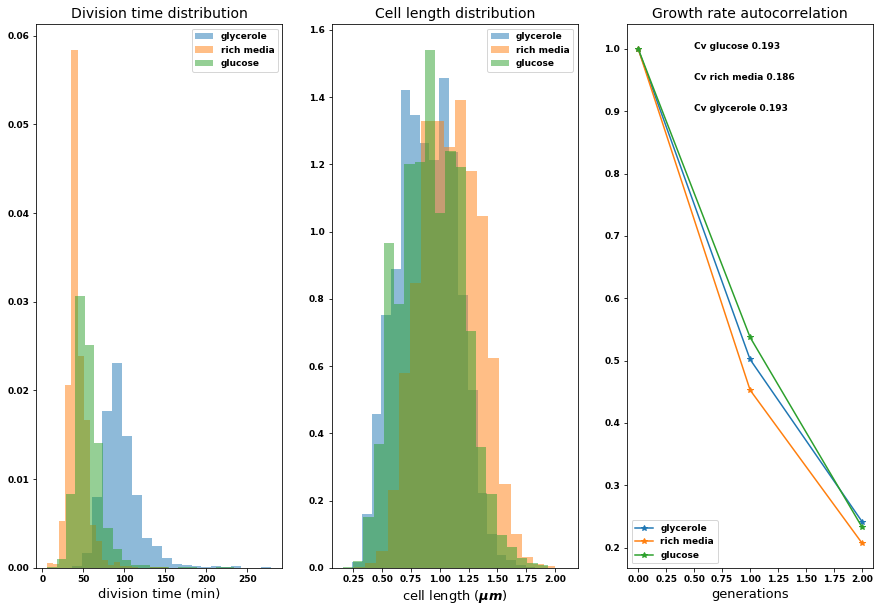

In [16]:
fig,axes = plt.subplots(1,3,figsize=(15,10))
i=0
for k in file_names.keys():
    if k=='glucose_guillaume':name='glucose'
    if k=='glucose_guillaume_8aa':name='rich media'
    if k=='glycerol_guillaume':name='glycerole'
    df = df_files[k]
    axes[0].hist(((df.groupby('cell')['time_sec'].last()-df.groupby('cell')['time_sec'].first()).values/60),density=1,bins=20,alpha=0.5,label=name)
    axes[1].hist(df.groupby('cell')['length_box_um'].apply(lambda x:np.log(x)).values,alpha=0.5,density=1,bins=20,label=name)
    axes[2].plot(range(3),[1,pa_fi_de[k]['corr_1_gen'],pa_fi_de[k]['corr_2_gen']],'*-',label=name)
    axes[2].text(0.5,0.9-i,'Cv {} {:.3}'.format(name,pa_fi_de[k]['cv_el_rat']))
    axes[0].set_xlabel('division time (min)')
    axes[1].set_xlabel(r'cell length ($\mu m$)')
    axes[2].set_xlabel(r'generations')
    axes[0].set_title('Division time distribution', fontsize=14)
    axes[1].set_title('Cell length distribution', fontsize=14)
    axes[2].set_title('Growth rate autocorrelation', fontsize=14)
    i=i-0.05
axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")
axes[2].legend(loc="lower left")



plt.savefig('basic_stat.png')

###### Infere parameters

For the inference we imagine that measurment noise is correlated. We therefore take data every "step" in order to have uncorrelated measurments. The variable nump represents the minimum number of datapoints per cell, in the original file, in order to do the decomposition. This means that all cells used for inference have at least nump observations during they life cycle. ( do figure for paper)

In [19]:
df_denoise = {}
for k in file_names.keys():
    for step in [1,2,3,4]:
        if 'gluc' in k: nump=15
        else: nump=27
        df_denoise[k+str(step)]= rl.give_unique_dataset(df_files[k],step,nump)


Do the inference **(already done)**. Note that depending on the initial condition we may not reach the global optimum. Therefore, repeat the inference several times and select the parameter set with the largest log likelihood. We usually do the minimization by assuming sd2 known in order to speed up the minimum search. See in the function inference how to fix a parameter.

In [ ]:
df_inferred = {}
for k in df_denoise.keys():
    df_inferred[k] = inference(df_denoise[k],'length_box_um',k)

We already run it and saved in the folder /inferred

In [19]:
param = {}
names = {'gluc_pap_fix1.pkl','gluc_pap_fix2.pkl','gluc_pap_fix3.pkl','gluc_pap_fix4.pkl','gluc_pap_fix5.pkl','rich_paper_fix1.pkl','rich_paper_fix2.pkl','rich_paper_fix3.pkl','rich_paper_fix4.pkl','rich_paper_fix5.pkl','glyc_paper_fix1.pkl','glyc_paper_fix2.pkl','glyc_paper_fix3.pkl','glyc_paper_fix4.pkl','glyc_paper_fix5.pkl','glyc_paper_fix6.pkl','glyc_paper_fix7.pkl','glyc_paper_fix8.pkl','glyc_paper_fix9.pkl'}


for n in names:
    with open(cwd+'/inference/{}'.format(n), 'rb') as f:
        param[n.replace('.pkl','')] = pickle.load(f)
        param[n.replace('.pkl','')]['ml']=param[n.replace('.pkl','')]['param'][0]
        param[n.replace('.pkl','')]['gamma']=param[n.replace('.pkl','')]['param'][1]
        param[n.replace('.pkl','')]['sl2']=param[n.replace('.pkl','')]['param'][2]
        param[n.replace('.pkl','')]['sm2']=param[n.replace('.pkl','')]['param'][3]
        param[n.replace('.pkl','')]['sd2']=param[n.replace('.pkl','')]['param'][4]
        param[n.replace('.pkl','')]['eml']=param[n.replace('.pkl','')]['error'][0]
        param[n.replace('.pkl','')]['egamma']=param[n.replace('.pkl','')]['error'][1]
        param[n.replace('.pkl','')]['esl2']=param[n.replace('.pkl','')]['error'][2]
        param[n.replace('.pkl','')]['esm2']=param[n.replace('.pkl','')]['error'][3]
        #param[n.replace('.pkl','')]['esd2']=param[n.replace('.pkl','')]['error'][4] #if fixed param 
        param[n.replace('.pkl','')]['media']=n[:4]
#Save as panda dataframe        
param = pd.DataFrame.from_dict(param).T
param.sort_values(by=['step'], inplace=True) 
param['tau'] = 1/param['gamma']
param['etau'] = param['egamma']/param['gamma']**2
param['cv'] = (param['sl2']/(2*param['gamma']*param['ml']**2)).apply(lambda x:np.sqrt(x))
param['ecv'] = 0.5/(param['sl2']/(2*param['gamma']*param['ml']**2)).apply(lambda x:np.sqrt(x))*(param['esl2']/(2*param['gamma']*param['ml']**2)+param['sl2']/(2*param['gamma']**2*param['ml']**2)*param['egamma']+2*param['sl2']/(2*param['gamma']*param['ml']**3)*param['eml'])
param['sm'] = param['sm2'].apply(lambda x:np.sqrt(x))
param['esm'] = param['sm2'].apply(lambda x:1/2*1/np.sqrt(x))*param['esm2']


The idea is that when the step size is large enough the correlation time inferred should converge

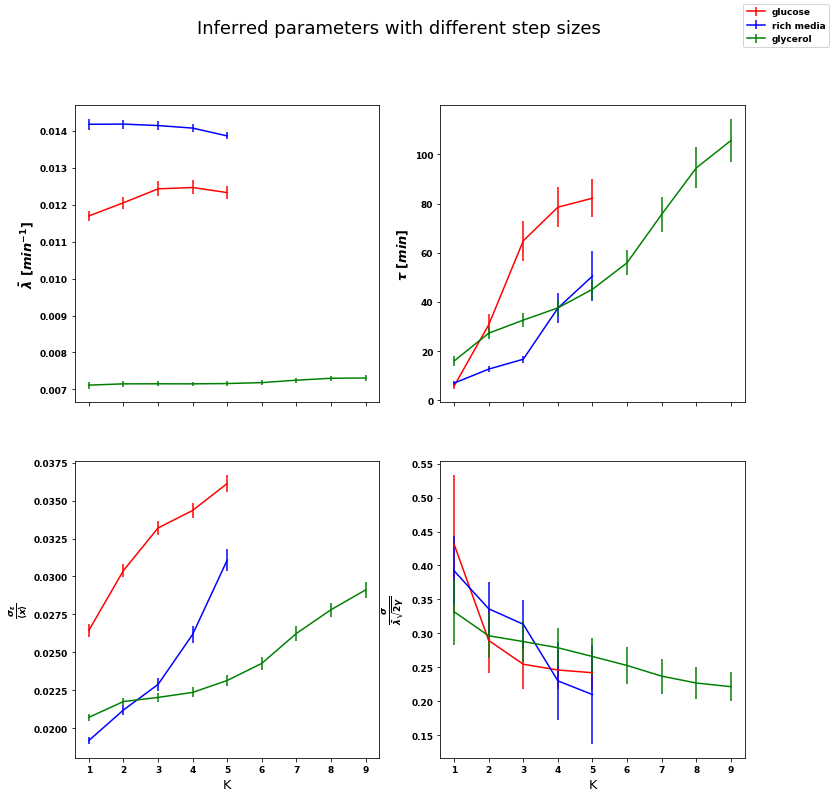

In [20]:
f, axes = plt.subplots( 2,2,figsize=(12,12),sharex=True)
med = param['media'].unique()
# mean growth rate
axes[0,0].errorbar(param.loc[param['media']==med[0]]['step'],param.loc[param['media']==med[0]]['ml'],2*param.loc[param['media']==med[0]]['eml'],color='r')
axes[0,0].errorbar(param.loc[param['media']==med[1]]['step'],param.loc[param['media']==med[1]]['ml'],2*param.loc[param['media']==med[1]]['eml'],color='b')
axes[0,0].errorbar(param.loc[param['media']==med[2]]['step'],param.loc[param['media']==med[2]]['ml'],2*param.loc[param['media']==med[2]]['eml'],color='g')

# tau
axes[0,1].errorbar(param.loc[param['media']==med[0]]['step'],param.loc[param['media']==med[0]]['tau'],2*param.loc[param['media']==med[0]]['etau'],color='r')
axes[0,1].errorbar(param.loc[param['media']==med[1]]['step'],param.loc[param['media']==med[1]]['tau'],2*param.loc[param['media']==med[1]]['etau'],color='b')
axes[0,1].errorbar(param.loc[param['media']==med[2]]['step'],param.loc[param['media']==med[2]]['tau'],2*param.loc[param['media']==med[2]]['etau'],color='g')

# error
axes[1,0].errorbar(param.loc[param['media']==med[0]]['step'],param.loc[param['media']==med[0]]['sm']/pa_fi_de['glucose_guillaume']['mean_log_length'].mean(),2*param.loc[param['media']==med[0]]['esm']/pa_fi_de['glucose_guillaume']['mean_log_length'].mean(),color='r')
axes[1,0].errorbar(param.loc[param['media']==med[1]]['step'],param.loc[param['media']==med[1]]['sm']/pa_fi_de['glucose_guillaume_8aa']['mean_log_length'].mean(),2*param.loc[param['media']==med[1]]['esm']/pa_fi_de['glucose_guillaume_8aa']['mean_log_length'].mean(),color='b')
axes[1,0].errorbar(param.loc[param['media']==med[2]]['step'],param.loc[param['media']==med[2]]['sm']/pa_fi_de['glycerol_guillaume']['mean_log_length'].mean(),2*param.loc[param['media']==med[2]]['esm']/pa_fi_de['glycerol_guillaume']['mean_log_length'].mean(),color='g')

# Cv
axes[1,1].errorbar(param.loc[param['media']==med[0]]['step'],param.loc[param['media']==med[0]]['cv'],2*param.loc[param['media']==med[0]]['ecv'],color='r',label='glucose')
axes[1,1].errorbar(param.loc[param['media']==med[1]]['step'],param.loc[param['media']==med[1]]['cv'],2*param.loc[param['media']==med[1]]['ecv'],color='b',label='rich media')
axes[1,1].errorbar(param.loc[param['media']==med[2]]['step'],param.loc[param['media']==med[2]]['cv'],2*param.loc[param['media']==med[2]]['ecv'],color='g',label='glycerol')

# Names
axes[0,0].set_ylabel(r'$\bar\lambda\ [min^{-1}]$')
axes[0,1].set_ylabel(r'$\tau\ [min]$')
axes[1,0].set_ylabel(r'$\frac{\sigma_\epsilon}{\langle x\rangle}$')
axes[1,1].set_ylabel(r'$\frac{\sigma}{\bar\lambda\sqrt{2\gamma}}$')



axes[1,0].set_xlabel('K')
axes[1,1].set_xlabel('K')

f.suptitle('Inferred parameters with different step sizes', fontsize=18)
f.legend(loc=1)
plt.savefig('inferred_param.png')

#### In order to test the validity of such results we run a computer simulation. Cell growth dynamics is generated using an OU model with the inferred parameters and cell division is assumed to follow the adder model

In [21]:
sim_path ={} 
for k in param.index:
    if 'glyc' in k: Dv = pa_fi_de['glycerol_guillaume']['length_after_division'].mean()
    if 'gluc' in k: Dv = pa_fi_de['glucose_guillaume']['length_after_division'].mean()
    if 'rich' in k: Dv = pa_fi_de['glucose_guillaume_8aa']['length_after_division'].mean()    
    sim_path[k] = rl.similar_frame(*param.loc[k]['param'][:-1].tolist(),DV=Dv,mq=0,gq=None,sq2=None,beta=None,shape=(9,6000))

Compute statistics

In [22]:
sim_stat={}
for k in sim_path.keys():
    sim_stat[k]=files_descriptions(sim_path[k],'leng')

Plot similar statistics for step=1 parameters

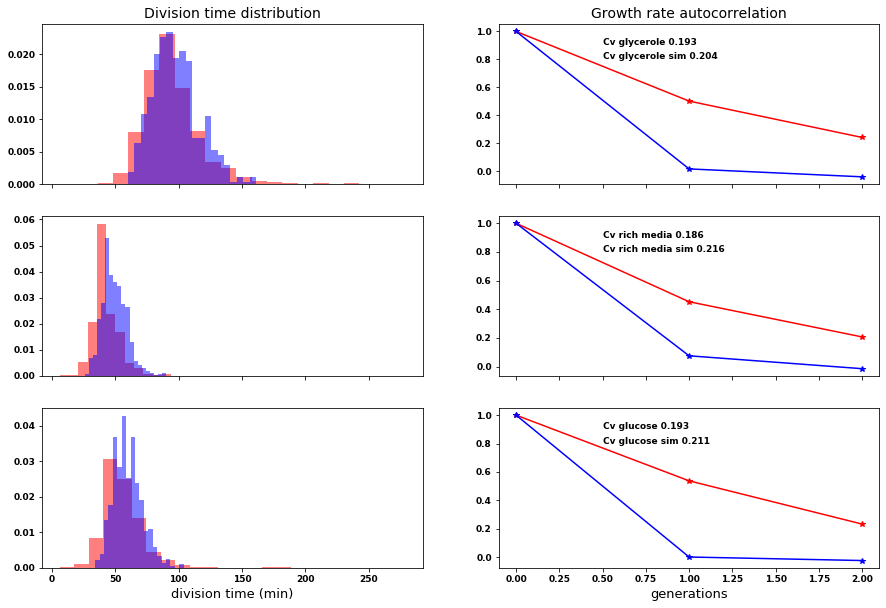

In [23]:
fig,axes = plt.subplots(3,2,figsize=(15,10), sharex='col')
i=0
l=0
for k,j in zip(['glycerol_guillaume', 'glucose_guillaume_8aa', 'glucose_guillaume'],['glyc_paper_fix1','rich_paper_fix1','gluc_pap_fix1']):
    if k=='glucose_guillaume':name='glucose'
    if k=='glucose_guillaume_8aa':name='rich media'
    if k=='glycerol_guillaume':name='glycerole'
    df = df_files[k]
    dfs = sim_path[j]
    div_time_true = ((df.groupby('cell')['time_sec'].last()-df.groupby('cell')['time_sec'].first()).values/60)
    div_time_sim = ((dfs.groupby('cell')['time_sec'].last()-dfs.groupby('cell')['time_sec'].first()).values/60)
    axes[l,0].hist(div_time_true,density=1,bins=20,alpha=0.5,color='r')
    axes[l,0].hist(div_time_sim,density=1,bins=20,alpha=0.5,color='b')
#    axes[l,1].hist(df.groupby('cell')['length_box_um'].apply(lambda x:np.log(x)).values,alpha=0.5,density=1,bins=20,color='r')
#    axes[l,1].hist(dfs.groupby('cell')['leng'].apply(lambda x:np.log(x)).values,alpha=0.5,density=1,bins=20,color='b')
    axes[l,1].plot(range(3),[1,pa_fi_de[k]['corr_1_gen'],pa_fi_de[k]['corr_2_gen']],'*-',color='r')
    axes[l,1].text(0.5,0.9,'Cv {} {:.3}'.format(name,pa_fi_de[k]['cv_el_rat']))
    axes[l,1].plot(range(3),[1,sim_stat[j]['corr_1_gen'],sim_stat[j]['corr_2_gen']],'*-',color='b')
    axes[l,1].text(0.5,0.8,'Cv {} sim {:.3}'.format(name,sim_stat[j]['cv_el_rat']))
    axes[2,0].set_xlabel('division time (min)')
#    axes[2,1].set_xlabel(r'cell length ($\mu m$)')
    axes[2,1].set_xlabel(r'generations')
    axes[0,0].set_title('Division time distribution', fontsize=14)
#    axes[0,1].set_title('Cell length distribution', fontsize=14)
    axes[0,1].set_title('Growth rate autocorrelation', fontsize=14)
    l+=1
plt.savefig('basic_stat_simulated_step1.png')

Plot similar statistics for good parameter sets

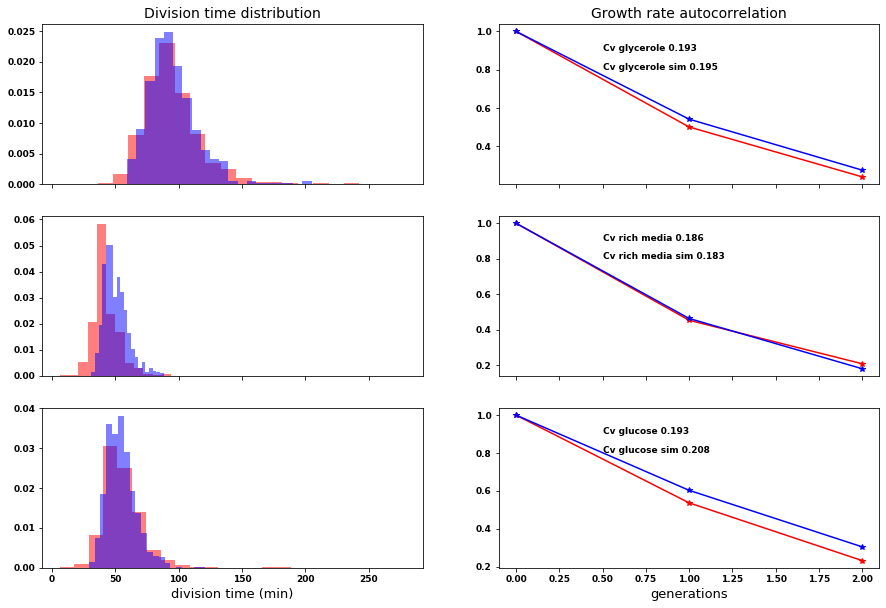

In [25]:
fig,axes = plt.subplots(3,2,figsize=(15,10), sharex='col')
i=0
l=0
for k,j in zip(['glycerol_guillaume', 'glucose_guillaume_8aa', 'glucose_guillaume'],['glyc_paper_fix9','rich_paper_fix5','gluc_pap_fix4']):
    if k=='glucose_guillaume':name='glucose'
    if k=='glucose_guillaume_8aa':name='rich media'
    if k=='glycerol_guillaume':name='glycerole'
    df = df_files[k]
    dfs = sim_path[j]
    div_time_true = ((df.groupby('cell')['time_sec'].last()-df.groupby('cell')['time_sec'].first()).values/60)
    div_time_sim = ((dfs.groupby('cell')['time_sec'].last()-dfs.groupby('cell')['time_sec'].first()).values/60)
    axes[l,0].hist(div_time_true,density=1,bins=20,alpha=0.5,color='r')
    axes[l,0].hist(div_time_sim,density=1,bins=20,alpha=0.5,color='b')
#    axes[l,1].hist(df.groupby('cell')['length_box_um'].apply(lambda x:np.log(x)).values,alpha=0.5,density=1,bins=20,color='r')
#    axes[l,1].hist(dfs.groupby('cell')['leng'].apply(lambda x:np.log(x)).values,alpha=0.5,density=1,bins=20,color='b')
    axes[l,1].plot(range(3),[1,pa_fi_de[k]['corr_1_gen'],pa_fi_de[k]['corr_2_gen']],'*-',color='r')
    axes[l,1].text(0.5,0.9,'Cv {} {:.3}'.format(name,pa_fi_de[k]['cv_el_rat']))
    axes[l,1].plot(range(3),[1,sim_stat[j]['corr_1_gen'],sim_stat[j]['corr_2_gen']],'*-',color='b')
    axes[l,1].text(0.5,0.8,'Cv {} sim {:.3}'.format(name,sim_stat[j]['cv_el_rat']))
    axes[2,0].set_xlabel('division time (min)')
#    axes[2,1].set_xlabel(r'cell length ($\mu m$)')
    axes[2,1].set_xlabel(r'generations')
    axes[0,0].set_title('Division time distribution', fontsize=14)
#    axes[0,1].set_title('Cell length distribution', fontsize=14)
    axes[0,1].set_title('Growth rate autocorrelation', fontsize=14)
    l+=1
plt.savefig('basic_stat_simulated.png')

#### Path predictions

In [26]:
#Predict paths
predicted_files={}
for k,j in zip(['glycerol_guillaume', 'glucose_guillaume_8aa', 'glucose_guillaume'],['glyc_paper_fix9','rich_paper_fix5','gluc_pap_fix4']):
    predicted_files[k]= predict(df_files[k],'length_box_um',j,param)


In [27]:
#Select mother and daugther cells to do a nice plot
excel = predicted_files['glycerol_guillaume'].loc[(predicted_files['glycerol_guillaume']['cell']=='c20180706010125')|(predicted_files['glycerol_guillaume']['cell']=='c20180706010136')]

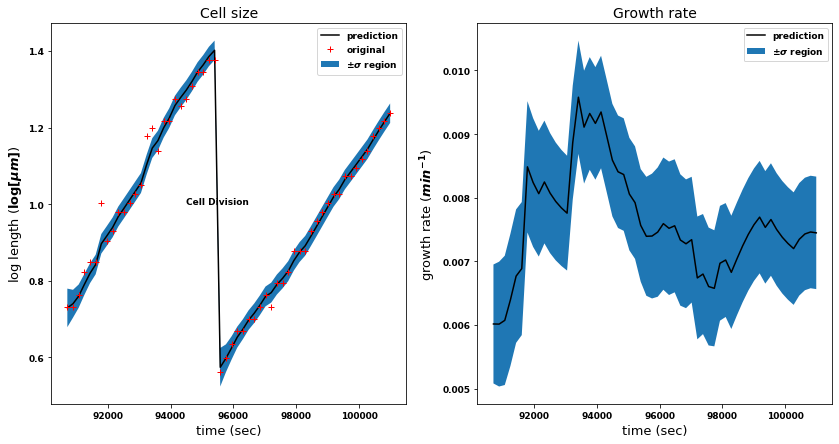

In [28]:
fig,axes = plt.subplots(1,2,figsize=(14,7))
axes[0].plot(excel['time_sec'],excel['pred_log_length'],'k',label='prediction')
axes[0].fill_between(excel['time_sec'],excel['pred_log_length']+2*excel['err_log_length'],excel['pred_log_length']-2*excel['err_log_length'],label=r'$\pm\sigma$ region')
axes[0].plot(excel['time_sec'],excel['log_resc_length_box_um'],'+r',label='original')
axes[1].plot(excel['time_sec'],excel['pred_growth_rate'],'k',label='prediction')
axes[1].fill_between(excel['time_sec'],excel['pred_growth_rate']+excel['err_growth_rate'],excel['pred_growth_rate']-excel['err_growth_rate'],label=r'$\pm\sigma$ region')
axes[0].set_xlabel('time (sec)')
axes[1].set_xlabel('time (sec)')
axes[0].set_ylabel(r'log length ($\log [\mu m]$)')
axes[1].set_ylabel(r'growth rate ($min^{-1}$)')
axes[0].set_title('Cell size', fontsize=14)
axes[1].set_title('Growth rate', fontsize=14)
axes[0].text(94500,1,'Cell Division')
axes[0].legend()
axes[1].legend()
plt.savefig('predicted_paths.png')

We can now compute quantities like the autocorrelation function

In [29]:
predict_correlation = {}
for key in pa_fi_de.keys():
    predict_correlation[key] = autocorrelation(predicted_files[key],int(3*pa_fi_de[key]['division_time'].mean()),step=6,vari='pred_growth_rate',acquisiton_time=3,division_time=pa_fi_de[key]['division_time'].mean())
    

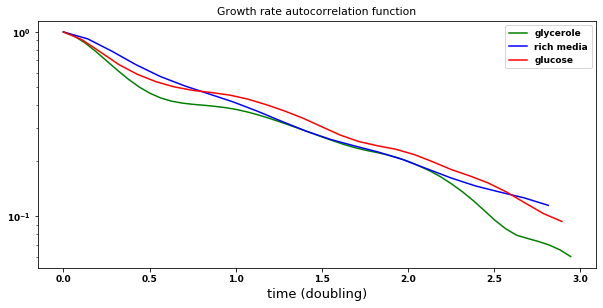

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1)
for key in predict_correlation.keys():
    if key == 'glycerol_guillaume': color='g';label='glycerole'
    if key == 'glucose_guillaume': color='r'; label='glucose'
    if key == 'glucose_guillaume_8aa': color='b'; label='rich media'   
    tmp_dat = predict_correlation[key]
    ax.plot(tmp_dat[1],tmp_dat[0][:,0],label=label,color=color)
    ax.set_xlabel('time (doubling)')
    ax.set_yscale('log')
    ax.set_title('Growth rate autocorrelation function')
plt.legend()
plt.savefig('autocorrelation.png')        

Other kind of statistics we can look at(if needed)

In [31]:
pred_file = {}
for key in predicted_files.keys():
    pred_file[key]=usefulquantities(predicted_files[key])

In [32]:
def binnedcorr(df,variable,bins,var_y='pred_growth_rate'):
    """Bin the variable and compute mean+std+number of points for growth rate """
    le = np.linspace(df['{}'.format(variable)].min(),df['{}'.format(variable)].max(),bins+1)
    bins = pd.IntervalIndex.from_tuples([(i,j) for i,j in zip(le[:-1],le[1:])])
    df['bin_var'] = pd.cut(df['{}'.format(variable)], bins)
    gro = df.groupby('bin_var').apply(lambda x: x['{}'.format(var_y)])
    #return gro.mean(),gro.std(),gro.size()
    gro = gro.reset_index()
    gro['bin_var'] =  gro['bin_var'].astype('str')
    gro['bin_var'] = gro['bin_var'].apply(lambda x:'('+';'.join(['{:.2f}'.format(float(i)) for  i in x.replace('(','').replace('[','').replace(']','').replace(')','').split(",")])+')')
    tmp =  gro[['bin_var','{}'.format(var_y)]].rename(columns={'bin_var':'bin_{}'.format(variable)})
    return tmp
    #return tmp.groupby('bin_{}'.format(variable)).mean().values.reshape(-1),tmp.groupby('bin_{}'.format(variable)).std().values.reshape(-1)/np.sqrt(len(tmp.values))

In [33]:
def plot_corr(df,var_x,var_y,one_per_cell,kind='reg',addsave='',fname='',ret=False):
    """Select 1 number per cell and plot the result"""
    if one_per_cell:
        ff =\
        df.dropna().groupby('cell')[['{}'.format(var_x),'{}'.format(var_y)]].first()
    else: ff=df
    g = sns.jointplot(x="{}".format(var_x), y="{}".format(var_y),\
                      data=ff,kind=kind)
    g.plot_joint(plt.scatter, c="w", s=0.1, marker="o")
    if kind=='reg':
        g.annotate(stats.pearsonr)
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Corr between {} and {} {} for\n {}".format(var_x,var_y,addsave,fname))
    g.savefig("Corr_between_{}_and_{}_{}.png".format(var_x,var_y,addsave),bbox_inches='tight')
    if ret: return ff

In [34]:
binned_growth_cc = {}
for key in pred_file.keys():
    binned_growth_cc[key] =  binnedcorr(pred_file[key],'cell_cycle',10,var_y='pred_growth_rate')

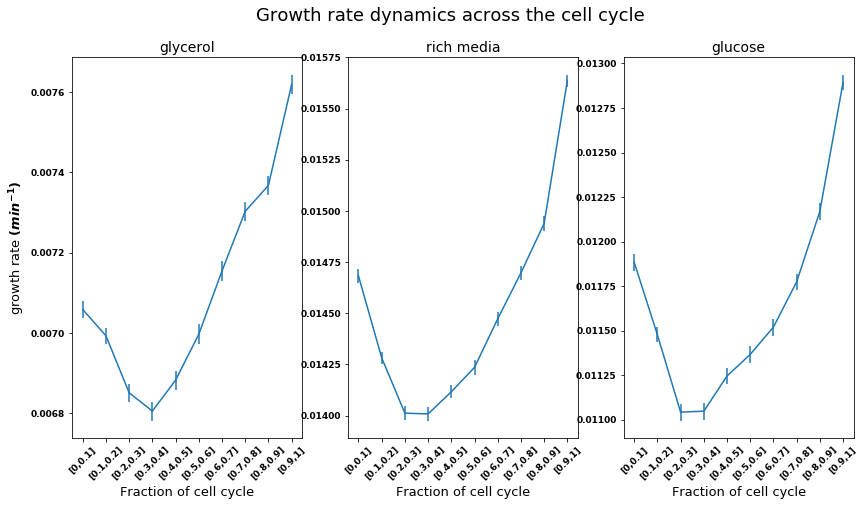

In [35]:
fig,axes = plt.subplots(1,3,figsize=(14,7))
labels=['[0,0.1]','[0.1,0.2]','[0.2,0.3]','[0.3,0.4]','[0.4,0.5]','[0.5,0.6]','[0.6,0.7]','[0.7,0.8]','[0.8,0.9]','[0.9,1]']
newname = {'glycerol_guillaume':'glycerol', 'glucose_guillaume_8aa':'rich media', 'glucose_guillaume':'glucose'}
s=0
for k in binned_growth_cc.keys():
    mean = binned_growth_cc[k].groupby('bin_cell_cycle').mean().values.reshape(-1)
    error = binned_growth_cc[k].groupby('bin_cell_cycle').std().values.reshape(-1)/np.sqrt(binned_growth_cc[k].groupby('bin_cell_cycle').count().values.reshape(-1))
    axes[s].errorbar(range(10),mean,error,label=k)
    axes[0].set_ylabel('growth rate $(min^{-1})$')
    axes[s].set_xticks(range(10))
    axes[s].set_xticklabels(['[0,0.1]','[0.1,0.2]','[0.2,0.3]','[0.3,0.4]','[0.4,0.5]','[0.5,0.6]','[0.6,0.7]','[0.7,0.8]','[0.8,0.9]','[0.9,1]'],rotation=45)
    axes[s].set_xlabel('Fraction of cell cycle')
    axes[s].set_title('{}'.format(newname[k]),fontsize=14)
    s+=1
plt.suptitle('Growth rate dynamics across the cell cycle',fontsize=18)
plt.savefig('gr_dyn_cell_cycle.png')